In [ ]:
#credits
https://towardsdatascience.com/predicate-vs-projection-pushdown-in-spark-3-ac24c4d11855
    https://www.bmc.com/blogs/python-spark-k-means-example/
- sampling: https://stackoverflow.com/questions/24806084/sampling-a-large-distributed-data-set-using-pyspark-spark
- filter pushing:

In [1]:
!pip install pyspark



In [1]:
from pyspark.sql import SparkSession


In [2]:
import glob

In [3]:
pwd()

'D:\\Bitcoin analysis'

In [4]:
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, TimestampType

In [5]:
from pyspark.sql import functions as F
#df.select(F.col("my_column"))

In [6]:
schema = StructType([ \
    StructField("value",IntegerType(),True), \
    StructField("fee",IntegerType(),True), \
    StructField("timestamp_in_unix_seconds",IntegerType(),True), \
  ])

In [7]:

# spark config
from pyspark.conf import SparkConf


config = SparkConf().setAll([ \
    ('spark.executor.memory', '8g'), \
    ('spark.executor.instances', '4'), \
    ('spark.driver.memory','16g'), \
    ("spark.sql.parquet.filterPushdown", "true"), \
    ("spark.hadoop.parquet.filter.stats.enabled", "true"), \
    ("spark.sql.optimizer.nestedSchemaPruning.enabled", "true"), \
    ("spark.sql.optimizer.dynamicPartitionPruning.enabled", "true") ])

In [8]:
print(config.setMaster("local").setAppName("Clustering using K-Means"))

print(config.get("spark.master"))

print(config.get("spark.app.name"))


local
Clustering using K-Means


In [9]:
import time

from datetime import datetime
spark = SparkSession.builder.appName("Clustering using K-Means") \
    .config(conf=config) \
    .getOrCreate() \
#    .option("failOnDataLoss", False)
#spark

In [10]:
spark

In [11]:
spark.sparkContext.getConf().getAll()

[('spark.master', 'local'),
 ('spark.executor.instances', '4'),
 ('spark.sql.parquet.filterPushdown', 'true'),
 ('spark.driver.port', '51693'),
 ('spark.executor.id', 'driver'),
 ('spark.sql.optimizer.dynamicPartitionPruning.enabled', 'true'),
 ('spark.driver.memory', '16g'),
 ('spark.app.id', 'local-1637776697631'),
 ('spark.sql.optimizer.nestedSchemaPruning.enabled', 'true'),
 ('spark.sql.warehouse.dir', 'file:/D:/Bitcoin%20analysis/spark-warehouse'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.executor.memory', '8g'),
 ('spark.submit.pyFiles', ''),
 ('spark.submit.deployMode', 'client'),
 ('spark.hadoop.parquet.filter.stats.enabled', 'true'),
 ('spark.app.startTime', '1637776694600'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.name', 'Clustering using K-Means'),
 ('spark.driver.host', '10.0.7.40')]

In [12]:
import glob
import os
BITCOIN_PATHS = sorted(glob.glob(os.path.join("D:\\Downloads\\bitcoin_data_filtered\\", "*")))
BITCOIN_PATHS

['D:\\Downloads\\bitcoin_data_filtered\\bitcoin000000000000',
 'D:\\Downloads\\bitcoin_data_filtered\\bitcoin000000000001',
 'D:\\Downloads\\bitcoin_data_filtered\\bitcoin000000000002',
 'D:\\Downloads\\bitcoin_data_filtered\\bitcoin000000000003',
 'D:\\Downloads\\bitcoin_data_filtered\\bitcoin000000000004',
 'D:\\Downloads\\bitcoin_data_filtered\\bitcoin000000000005',
 'D:\\Downloads\\bitcoin_data_filtered\\bitcoin000000000006',
 'D:\\Downloads\\bitcoin_data_filtered\\bitcoin000000000007',
 'D:\\Downloads\\bitcoin_data_filtered\\bitcoin000000000008',
 'D:\\Downloads\\bitcoin_data_filtered\\bitcoin000000000009',
 'D:\\Downloads\\bitcoin_data_filtered\\bitcoin000000000010',
 'D:\\Downloads\\bitcoin_data_filtered\\bitcoin000000000011',
 'D:\\Downloads\\bitcoin_data_filtered\\bitcoin000000000012',
 'D:\\Downloads\\bitcoin_data_filtered\\bitcoin000000000013',
 'D:\\Downloads\\bitcoin_data_filtered\\bitcoin000000000014',
 'D:\\Downloads\\bitcoin_data_filtered\\bitcoin000000000015',
 'D:\\Do

In [13]:
# hier wird dataframe gelesen. versuche es mit rdd .rdd()
data_customer=spark.read.csv(BITCOIN_PATHS, header=True, schema=schema) \
    .select("value","fee") \
    .filter((F.col('timestamp_in_unix_seconds') >= int(time.mktime(datetime.strptime('2018-12-16', '%Y-%m-%d').timetuple()))) & (F.col('timestamp_in_unix_seconds') <= int(time.mktime(datetime.strptime('2021-04-13', '%Y-%m-%d').timetuple())))) \
    .persist()
data_customer.printSchema()

root
 |-- value: integer (nullable = true)
 |-- fee: integer (nullable = true)



In [14]:
data_customer.explain()

== Physical Plan ==
*(1) ColumnarToRow
+- InMemoryTableScan [value#0, fee#1]
      +- InMemoryRelation [value#0, fee#1], StorageLevel(disk, memory, deserialized, 1 replicas)
            +- *(1) Project [value#0, fee#1]
               +- *(1) Filter ((isnotnull(timestamp_in_unix_seconds#2) AND (timestamp_in_unix_seconds#2 >= 1544914800)) AND (timestamp_in_unix_seconds#2 <= 1618264800))
                  +- FileScan csv [value#0,fee#1,timestamp_in_unix_seconds#2] Batched: false, DataFilters: [isnotnull(timestamp_in_unix_seconds#2), (timestamp_in_unix_seconds#2 >= 1544914800), (timestamp_..., Format: CSV, Location: InMemoryFileIndex[file:/D:/Downloads/bitcoin_data_filtered/bitcoin000000000000, file:/D:/Download..., PartitionFilters: [], PushedFilters: [IsNotNull(timestamp_in_unix_seconds), GreaterThanOrEqual(timestamp_in_unix_seconds,1544914800), ..., ReadSchema: struct<value:int,fee:int,timestamp_in_unix_seconds:int>




In [15]:
data_customer=data_customer.na.drop()

In [16]:
data_customer.show(2)

+------+-----+
| value|  fee|
+------+-----+
|291584|36400|
|202651| 4698|
+------+-----+
only showing top 2 rows



In [17]:
data_customer = data_customer.sample(False,0.0001,1234)

In [18]:
inputCols=[ 'value', 'fee']

In [19]:
# transformation task. genau wie filter, join, etc. --> bis hier wird das aber nur vorbereitet
from pyspark.ml.feature import VectorAssembler
data_customer.columns
assemble=VectorAssembler(inputCols=[ 'value', 'fee'], outputCol='features')
assembled_data=assemble.transform(data_customer)
assembled_data.show(2)

+--------+-----+--------------------+
|   value|  fee|            features|
+--------+-----+--------------------+
| 5756560| 2350|  [5756560.0,2350.0]|
|25624323|11234|[2.5624323E7,1123...|
+--------+-----+--------------------+
only showing top 2 rows



In [20]:
# an dieser stelle findet erstmals eine aktion statt. die vorbereiteten transformationen werden durchgeführt.
#standarizer
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized', withMean=True, withStd=True)
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)
data_scale_output.show(2)

+--------+-----+--------------------+--------------------+
|   value|  fee|            features|        standardized|
+--------+-----+--------------------+--------------------+
| 5756560| 2350|  [5756560.0,2350.0]|[-0.2914582798450...|
|25624323|11234|[2.5624323E7,1123...|[-0.2102908642003...|
+--------+-----+--------------------+--------------------+
only showing top 2 rows



In [21]:
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized_for_pca', withMean=True, withStd=False) # center it, but not scale it https://datascience-enthusiast.com/Python/PCA_Spark_Python_R.html
data_scale=scale.fit(data_scale_output)
data_scale_output=data_scale.transform(data_scale_output)
#data_scale_output = data_scale_output.filter((F.col('standardized_for_pca') <300))
data_scale_output.show(2)

+--------+-----+--------------------+--------------------+--------------------+
|   value|  fee|            features|        standardized|standardized_for_pca|
+--------+-----+--------------------+--------------------+--------------------+
| 5756560| 2350|  [5756560.0,2350.0]|[-0.2914582798450...|[-7.1341732176149...|
|25624323|11234|[2.5624323E7,1123...|[-0.2102908642003...|[-5.1473969176149...|
+--------+-----+--------------------+--------------------+--------------------+
only showing top 2 rows



In [22]:
#from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import PCA
pca = PCA(k=2, inputCol="standardized_for_pca")
pca.setOutputCol("pca_features")
model = pca.fit(data_scale_output)
data_scale_output = model.transform(data_scale_output)

In [23]:
data_scale_output.show(2)

+--------+-----+--------------------+--------------------+--------------------+--------------------+
|   value|  fee|            features|        standardized|standardized_for_pca|        pca_features|
+--------+-----+--------------------+--------------------+--------------------+--------------------+
| 5756560| 2350|  [5756560.0,2350.0]|[-0.2914582798450...|[-7.1341732176149...|[7.13417325988974...|
|25624323|11234|[2.5624323E7,1123...|[-0.2102908642003...|[-5.1473969176149...|[5.14739693701861...|
+--------+-----+--------------------+--------------------+--------------------+--------------------+
only showing top 2 rows



In [43]:
#data_customer = data_scale_output.toPandas()

In [24]:
%%time
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    
    KMeans_algo=KMeans(featuresCol='standardized', k=i, seed=1) # set seed
    
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    
    output=KMeans_fit.transform(data_scale_output)
    
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score:",score)

Silhouette Score: 0.9381982044640379
Silhouette Score: 0.9598415138509937
Silhouette Score: 0.9153493616493976
Silhouette Score: 0.9317376734936202
Silhouette Score: 0.926663078003905
Silhouette Score: 0.9385952276011137
Silhouette Score: 0.8972180998070991
Silhouette Score: 0.8867098493963451
Wall time: 19min 28s


Text(0, 0.5, 'silhouette score')

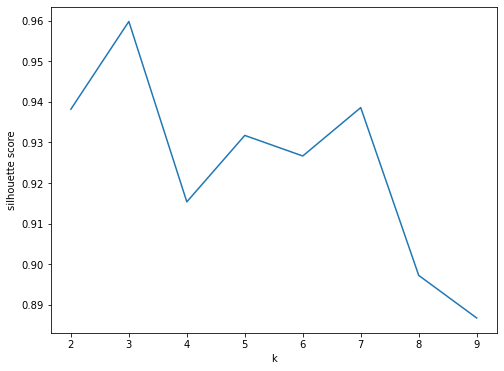

In [26]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score) # passe range an grösse des k an
ax.set_xlabel("k")
ax.set_ylabel("silhouette score")

In [46]:
type(data_customer)

pyspark.sql.dataframe.DataFrame

In [21]:



from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans

# Trains a k-means model.
kmeans = KMeans(featuresCol='standardized').setK(4).setSeed(1)
model = kmeans.fit(data_scale_output)

# Make predictions
predictions = model.transform(data_scale_output)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()


silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette)) 
# evaluation mit silhouette; evaluation mit SSE ist depriciated



Silhouette with squared euclidean distance = 0.9436336572675199


In [48]:
%%sql
display(predictions, data_scale_output)

UsageError: Cell magic `%%sql` not found.


In [30]:
# Shows the result.
print("Cluster Centers: ")
ctr=[]
centers = model.clusterCenters()
for center in centers:
    ctr.append(center)
    print(center)

Cluster Centers: 
[-0.23615234 -0.05044032]
[5.32334921 0.08243789]
[1.75994037 0.45316096]
[ 1.08377486 25.28391804]


In [22]:
# output of transform "output" or "predictions"
pandasDF=predictions.toPandas()

In [33]:
pandasDF
#wieso wurden orignaldaten in model gegeben? wieso nicht einfach nur standardized? 
# -- tatsächlich wurden nur standardized /features bearbeitet

,value,fee,features,standardized,standardized_for_pca,pca_features,prediction
0,5756560,2350,"[5756560.0, 2350.0]","[-0.2914582798450074, -0.19171781671300592]","[-71341732.17614995, -16880.32121900434]","[71341732.59889749, -14987.533661821673]",0
1,25624323,11234,"[25624323.0, 11234.0]","[-0.21029086420039356, -0.09081801382532093]","[-51473969.17614995, -7996.321219004341]","[51473969.37018612, -6630.650870128793]",0
2,17204912,6999,"[17204912.0, 6999.0]","[-0.24468738041209961, -0.13891691806095194]","[-59893380.17614995, -12231.321219004341]","[59893380.47958285, -10642.273108616428]",0
3,97600,7347,"[97600.0, 7347.0]","[-0.31457729724199585, -0.13496451695729206]","[-77000692.17614995, -11883.321219004341]","[77000692.46432899, -9840.394205030001]",0
4,3547909,573,"[3547909.0, 573.0]","[-0.3004814644748468, -0.2119000487854301]","[-73550383.17614995, -18657.32121900434]","[73550383.64526622, -16705.93532064131]",0
...,...,...,...,...,...,...,...
26410,1859098,23039,"[1859098.0, 23039.0]","[-0.30738090375153815, 0.04325697188934831]","[-75239194.17614995, 3808.6787809956586]","[75239194.04862009, 5804.870990834383]",0
26411,7236504,2712,"[7236504.0, 2712.0]","[-0.2854121422008875, -0.18760641096724479]","[-69861788.17614995, -16518.32121900434]","[69861788.58981404, -14664.798472240174]",0
26412,9618009,6249,"[9618009.0, 6249.0]","[-0.27568278282637076, -0.14743502388780513]","[-67480283.17614995, -12981.321219004341]","[67480283.49681106, -11190.98285210497]",0
26413,3044236,9126,"[3044236.0, 9126.0]","[-0.3025391614455611, -0.1147595699359963]","[-74054056.17614995, -10104.321219004341]","[74054056.41816692, -8139.572233701048]",0


In [34]:
import pandas as pd
centers = pd.DataFrame(ctr,columns=inputCols)
centers # könnte man einzeichnen, wenn man plot mit skalierten daten (nicht pca -daten) macht

,value,fee
0,-0.236152,-0.050440
1,5.323349,0.082438
2,1.759940,0.453161
3,1.083775,25.283918


In [35]:
data_pca.dtypes

NameError: name 'data_pca' is not defined

In [36]:
# plot pca
#pca_pandas = pandasDF.toPandas()
x = []
y = []
for i, j in pandasDF["pca_features"].values:
    x.append(i)
    y.append(j)

No handles with labels found to put in legend.


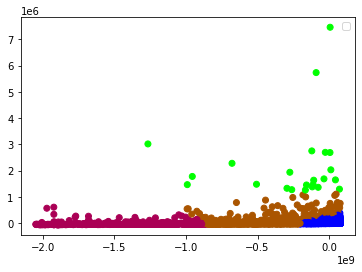

In [37]:
import matplotlib.pyplot as plt
plt.scatter(y=y,x=x, c=pandasDF["prediction"].values, cmap='brg')
plt.legend()

In [23]:
# bring scaled values(value, fee) into list
x = []
y = []
for i, j in pandasDF["standardized"].values:
    x.append(i)
    y.append(j)

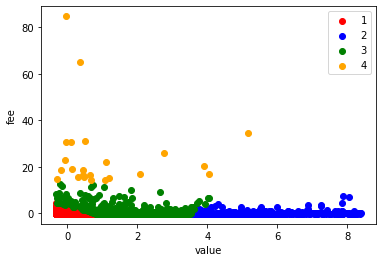

In [24]:
import matplotlib.pyplot as plt

# plot mit scaled daten: value vs. fee
#todo: outlier entfernen
#todo: mean centers rein tun
import numpy as np
scatter_x = np.array(x) # scaled bitcoin transaction value
scatter_y = np.array(y) # scaled bitcoin transaction fee
group = np.array(pandasDF['prediction'])

cdict = {0: 'red', 1: 'blue', 2: 'green', 3: 'orange'}
fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g+1)
ax.legend()
plt.xlabel("value")
plt.ylabel("fee")
plt.show()

#plt.scatter(y=pandasDF["fee"],x=pandasDF["value"], c=pandasDF["prediction"], cmap='brg')
#plt.legend()

#plt.scatter(y=y,x=x, c=pandasDF["prediction"].values, cmap='brg')
#plt.legend()





In [ ]:
# interpretation:
- 2010-2011 waren fees sehr günstig. zum teil waren transaktionen auch gratis. daher ist fee relativ weit unten
- fee plot ist auch etwas gezerrt wegen outlier oben
- die drei cluster
-- transaktionen mit wenig fee und wenig betrag
-- transaktionen mit wenig fee und viel betrag
-- transaktionen mit etwas höherem fees haben etwas höheren betrag

In [ ]:
# bezug zu orignaldaten machen: im folgenden wird nicht mit skalierten werten gearbeitet, damit mehr einblick in daten möglich wird

In [25]:
class1 = pandasDF.loc[pandasDF['prediction'] == 0]
class2 = pandasDF.loc[pandasDF['prediction'] == 1]
class3 = pandasDF.loc[pandasDF['prediction'] == 2]
class4 = pandasDF.loc[pandasDF['prediction'] == 3]

{'whiskers': [<matplotlib.lines.Line2D at 0x26d4ea81bb0>,
 'caps': [<matplotlib.lines.Line2D at 0x26d4ea875e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x26d4ea81c10>,
 'medians': [<matplotlib.lines.Line2D at 0x26d4ea8c1c0>,
 'fliers': [<matplotlib.lines.Line2D at 0x26d4ea8cd30>,
 'means': []}

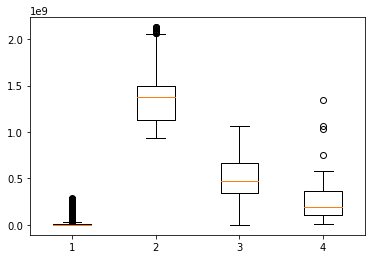

In [26]:
plt.boxplot([class1["value"], class2["value"], class3["value"], class4["value"]])

{'whiskers': [<matplotlib.lines.Line2D at 0x26d4eb2a220>,
 'caps': [<matplotlib.lines.Line2D at 0x26d4eb2e940>,
 'boxes': [<matplotlib.lines.Line2D at 0x26d4eb26e20>,
 'medians': [<matplotlib.lines.Line2D at 0x26d4eb31df0>,
 'fliers': [<matplotlib.lines.Line2D at 0x26d4eb351c0>,
 'means': []}

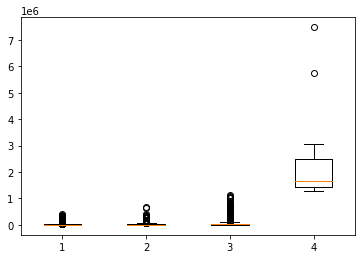

In [27]:
plt.boxplot([class1["fee"], class2["fee"], class3["fee"], class4["fee"]])

(0.0, 10.0)

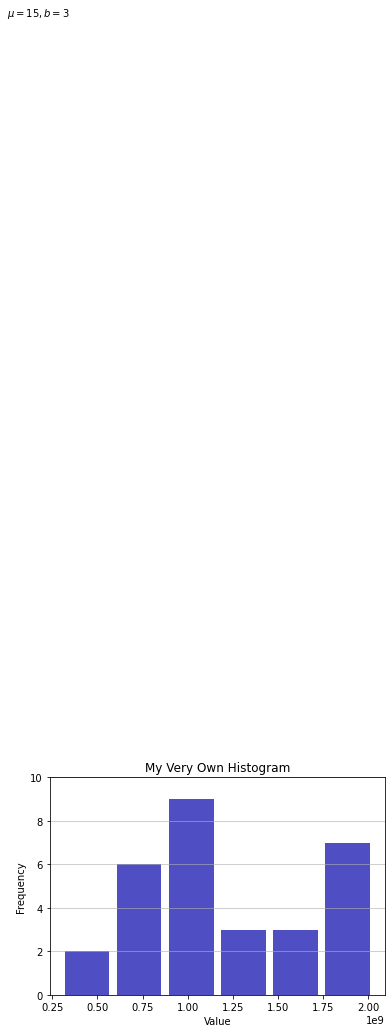

In [196]:
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=class3["value"], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('My Very Own Histogram')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)


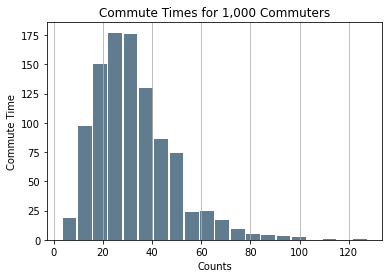

In [110]:
import pandas as pd

# Generate data on commute times.
size, scale = 1000, 10
commutes = pd.Series(np.random.gamma(scale, size=size) ** 1.5)

commutes.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Commute Times for 1,000 Commuters')
plt.xlabel('Counts')
plt.ylabel('Commute Time')
plt.grid(axis='y', alpha=0.75)

In [106]:
hist, bin_edges = np.histogram(class1["value"])

In [108]:
bin_edges, hist

(array([3.03000000e+08, 4.87424541e+08, 6.71849081e+08, 8.56273622e+08,
        1.04069816e+09, 1.22512270e+09, 1.40954724e+09, 1.59397178e+09,
        1.77839632e+09, 1.96282087e+09, 2.14724541e+09]),
 array([    6,    20,  5921, 14805,  8915,  7686,  8019,  7191,  7198,
         8992], dtype=int64))

In [92]:
a

NameError: name 'a' is not defined

In [70]:
class1.dtypes

value         int32
fee           int32
prediction    int32
dtype: object

In [53]:
class1["value"].std()

412539632.952635

In [54]:
class1["fee"].std()

816439.9690566078

In [55]:
class1["value"].mean()

1385349791.0699751

In [56]:
class2["value"].std()

192527991.7040208

In [57]:
class2["fee"].std()

494607.6801251146

In [58]:
class1["fee"].mean()

307382.71877590794

In [59]:
class2["value"].mean()

138226635.02230284

In [60]:
class2["fee"].mean()

219192.35550517545

In [61]:
class3["value"].std()

513883523.4715998

In [62]:
class3["fee"].std()

46099294.37783969

In [63]:
class3["value"].mean()

1215000002.3666666

In [64]:
class3["value"].mean()

1215000002.3666666